In [603]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils
from tensorflow.keras import Sequential, layers, losses, optimizers, models
import tensorflow as tf


In [604]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## 데이터 전처리

In [605]:
excel_data=pd.read_excel('data.xlsx', sheet_name='ResultWeight_MainDimension', header=1)

In [606]:
data=excel_data[1:]
corr=excel_data[0:1]

In [607]:
data.rename(columns={'거리1':'D1', '거리2':'D2'}, inplace=True)
data.rename(columns={'폭1':'W1', '폭2':'W2','높이2':'H1','면적2':'A1','둘레2':'G1'}, inplace=True)
data.rename(columns = {'폭1.1':'W3','폭2.1':'W4','높이1':'H2','높이2.1':'H3','면적1':'A2','면적2.1':'A3','둘레1':'G2','둘레2.1':'G3'}, inplace=True)
data.rename(columns = {'폭1.2':'W5','폭2.2':'W6','높이1.1':'H4','높이2.2':'H5','면적1.1':'A4','면적2.2':'A5','둘레1.1':'G4','둘레2.2':'G5'}, inplace=True)
data.rename(columns = {'폭1.3':'W7','폭2.3':'W8','높이1.2':'H6','높이2.3':'H7','면적1.2':'A6','면적2.3':'A7','둘레1.2':'G6','둘레2.3':'G7'}, inplace=True)
data.rename(columns = {'폭1.4':'W9','폭2.4':'W10','높이2.4':'H8','면적2.4':'A8','둘레2.4':'G8'}, inplace=True)

data.rename(columns = {'평균':'W_Mean','편차':'W_Dev','최대':'W_Max','최소':'W_Min'}, inplace=True)
data.rename(columns = {'평균.1':'H_Mean','편차.1':'H_Dev','최대.1':'H_Max','최소.1':'H_Min'}, inplace=True)
data.rename(columns = {'평균.2':'WH_Mean','편차.2':'WH_Dev','최대.2':'WH_Max','최소.2':'WH_Min'}, inplace=True)
data.rename(columns = {'평균.3':'A_Mean','편차.3':'A_Dev','최대.3':'A_Max','최소.3':'A_Min'}, inplace=True)
data.rename(columns = {'평균.4':'G_Mean','편차.4':'G_Dev','최대.4':'G_Max','최소.4':'G_Min'}, inplace=True)
data.rename(columns = {'무게':'Weight', '체형':'Shape'}, inplace=True)

data_area=pd.concat([data['A1'], data['A2'], data['A3'],data['A4'],data['A5'],data['A6'],data['A7'],data['A8']], axis=1)
data_width=pd.concat([data['W1'], data['W2'], data['W3'],data['W4'],data['W5'],data['W6'],data['W7'],data['W8'],data['W9'],data['W10']], axis=1)
data_height=pd.concat([data['H1'], data['H2'], data['H3'],data['H4'],data['H5'],data['H6'],data['H7'],data['H8']], axis=1)
data_girth=pd.concat([data['G1'], data['G2'], data['G3'],data['G4'],data['G5'],data['G6'],data['G7'],data['G8']], axis=1)

   
data_top10=pd.concat([data['A7'], data['A4'], data['A3'], data['W_Max'], data['W_Mean'], 
                      data['W9'], data['W_Mean'], data['H6'], data['H3'], data['W1']], axis=1)
                 
data_co10=pd.concat([data['A_Mean'], data['A7'], data['A4'], data['A5'], data['A3'], 
                      data['W_Max'], data['W_Mean'], data['W9'], data['A6'], data['A_Max']], axis=1) 

data_area_width_height_girth=pd.concat([data_area,data_width,data_height,data_girth ], axis=1)

C:\Users\CDELab\AppData\Local\Temp\ipykernel_23140\1154377114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'거리1':'D1', '거리2':'D2'}, inplace=True)
C:\Users\CDELab\AppData\Local\Temp\ipykernel_23140\1154377114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'폭1':'W1', '폭2':'W2','높이2':'H1','면적2':'A1','둘레2':'G1'}, inplace=True)
C:\Users\CDELab\AppData\Local\Temp\ipykernel_23140\1154377114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [608]:
Corr = excel_data[0:1].to_numpy()[0,1:excel_data.shape[1]-2]
data_selected = data_area_width_height_girth.to_numpy()

data_train = data_selected[0:696]
Y=data['Shape'].to_numpy()

Shuff = np.arange(696)
np.random.shuffle(Shuff)

X, y_train, X_Unlabeled, y_None =data_train[Shuff],Y[0:696][Shuff], data_selected[696:], Y[696:]


In [609]:
X_Unlabeled.shape

(326, 34)

In [610]:
def aCut(TotalArr,Corr,TH):
    SelectedArr = []
    for corr,index in zip(Corr,range(Corr.shape[0])):
        if(corr > TH):
            arr = TotalArr[:,index].tolist()
            SelectedArr.append(arr)
    SelectedArr = np.array(SelectedArr).transpose()
    return SelectedArr
def pre(data):
    X_max = np.max(data,0)
    arr = data/X_max
    arr = arr.astype('float32')
    return arr

In [611]:
X_train = X
y_train = np.array(y_train, dtype =('uint8'))


## 모델 생성

In [612]:

#optimizer = optimizers.SGD(learning_rate=0.1)
# 적응형 학습률 ("자동 변속")
#optimizer = optimizers.Adagrad()
#optimizer = optimizers.RMSprop()
optimizer = optimizers.Adam()
checkpoint_path = './tmp/checkpoint.ckpt'

In [613]:
model = models.Sequential()
model_check_point = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
model.add(tf.keras.layers.Dense(X_train.shape[1], input_dim =X_train.shape[1],activation = 'relu'))
model.add(tf.keras.layers.Dense(X_train.shape[1],activation = 'relu'))
model.add(tf.keras.layers.Dense(4,  activation='softmax'))
model.compile(
    loss=sparse_categorical_crossentropy, 
    optimizer=optimizer, 
    metrics=['acc'])
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 34)                1190      
                                                                 
 dense_85 (Dense)            (None, 34)                1190      
                                                                 
 dense_86 (Dense)            (None, 4)                 140       
                                                                 
Total params: 2,520
Trainable params: 2,520
Non-trainable params: 0
_________________________________________________________________


In [614]:
X_train_max = np.max(X_train,0)
from sklearn.preprocessing import MinMaxScaler #표준화
sc = MinMaxScaler() # preprocessing 모듈에서 MinMaxScalerr 클래스를 로드
sc.fit(X_train) # 각 특성마다 샘플평균과 표준편차를 계산
X_train_std = sc.transform(X_train) # X_train 값을 표준화



## 학습 데이터를 이용하여 1차 학습 진행

In [615]:
history1_1 = model.fit(X_train_std, y_train, batch_size=64, epochs=200, validation_split=0.2, callbacks =[model_check_point])

Epoch 1/200
9/9 [==============================] - 1s 29ms/step - loss: 1.6714 - acc: 0.0612 - val_loss: 1.4351 - val_acc: 0.2643
Epoch 2/200
9/9 [==============================] - 0s 9ms/step - loss: 1.3303 - acc: 0.2644 - val_loss: 1.2178 - val_acc: 0.2714
Epoch 3/200
9/9 [==============================] - 0s 9ms/step - loss: 1.1733 - acc: 0.3004 - val_loss: 1.0959 - val_acc: 0.4071
Epoch 4/200
9/9 [==============================] - 0s 9ms/step - loss: 1.0807 - acc: 0.5144 - val_loss: 1.0054 - val_acc: 0.5786
Epoch 5/200
9/9 [==============================] - 0s 8ms/step - loss: 0.9934 - acc: 0.5917 - val_loss: 0.9206 - val_acc: 0.6071
Epoch 6/200
9/9 [==============================] - 0s 8ms/step - loss: 0.9299 - acc: 0.5953 - val_loss: 0.8790 - val_acc: 0.6071
Epoch 7/200
9/9 [==============================] - 0s 9ms/step - loss: 0.9054 - acc: 0.5953 - val_loss: 0.8586 - val_acc: 0.6071
Epoch 8/200
9/9 [==============================] - 0s 9ms/step - loss: 0.8865 - acc: 0.5953 - va

In [616]:
import pandas as pd

train_results = pd.DataFrame(history1_1.history)
train_results[-5:]

,loss,acc,val_loss,val_acc
195,0.273636,0.904676,0.388038,0.857143
196,0.273792,0.899281,0.341286,0.857143
197,0.269632,0.904676,0.346525,0.871429
198,0.264946,0.920863,0.340744,0.871429
199,0.266927,0.919065,0.351711,0.864286


<AxesSubplot:>

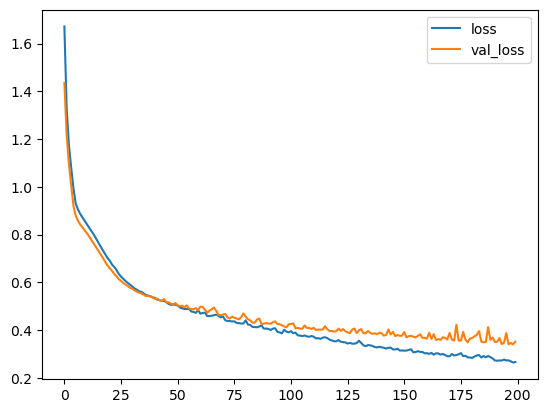

In [617]:
train_results[['loss', 'val_loss']].plot()

In [618]:
#model.load_weights(checkpoint_path)

## 학습 이상치를 제거한 후 2차 전이학습 시행

In [619]:
Y_pred = model.predict(X_train_std)
Y_pred_max = np.max(Y_pred,axis =1)

y_pred = np.argmax(Y_pred, axis=1)
X_train_selected = []
y_pred_selected =[]
cnt = 0
for i,j,k,m in zip(y_pred,y_train,range(X_train.shape[0]),Y_pred_max):
    if(i==j):
        cnt=cnt+1
        X_train_selected.append(X_train[k])
        y_pred_selected.append(i)
    else:
        if(m < 0.6):
            X_train_selected.append(X_train[k])
            y_pred_selected.append(i)
        
print(f'{cnt} of {y_train.shape[0]} are correct [{cnt/y_train.shape[0]*100}%]')

22/22 [==============================] - 0s 855us/step
631 of 696 are correct [90.66091954022988%]


In [620]:
X_train_selected = np.array(X_train_selected)
y_pred_selected = np.array(y_pred_selected)

In [621]:
#history1_2 = model.fit(pre(X_train_selected), y_pred_selected, batch_size = 64, epochs = 1000, validation_split = 0.2, callbacks = model_check_point)

In [622]:
Y_Unlabeled_pred = model.predict(sc.transform(X_Unlabeled))
Y_Unlabeled_pred = np.argmax(Y_Unlabeled_pred, axis=1)

11/11 [==============================] - 0s 898us/step


In [623]:
y_None = Y_Unlabeled_pred

In [624]:
Y_Unlabeled_pred.shape

(326,)

## 전체 데이터 병합

In [625]:
X_merge = np.concatenate((X_train_selected, X_Unlabeled), axis = 0)
y_merge = np.concatenate((y_pred_selected, Y_Unlabeled_pred))

In [626]:
X_train.shape

(696, 34)

In [627]:
X_train_selected.shape

(645, 34)

In [628]:
X_merge.shape

(971, 34)

In [629]:
y_merge = np.reshape(y_merge, (X_merge.shape[0],1))

In [630]:
data_merge = np.concatenate((X_merge,y_merge), axis = 1)
np.random.shuffle(data_merge)

In [631]:
split = round(X_merge.shape[0]*0.7)

In [632]:
X2_train, y2_train, X2_test, y2_test = data_merge[:split,0:-1], data_merge[:split,-1], data_merge[split:,0:-1], data_merge[split:,-1]

In [633]:
X2_train.shape

(680, 34)

In [634]:
X2_test.shape

(291, 34)

## 평가 학습 모델

In [635]:
model2 = models.Sequential()
#model2.load_weights(checkpoint_path)
checkpoint_path2 = './tmp2/checkpoint'
model_check_point2 = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path2, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)

model2.add(tf.keras.layers.Dense(X_train.shape[1], input_dim =X_train.shape[1],activation = 'relu'))
model2.add(tf.keras.layers.Dense(X_train.shape[1],activation = 'relu'))
model2.add(tf.keras.layers.Dense(4,  activation='softmax'))
model2.compile(
    loss=sparse_categorical_crossentropy, 
    optimizer=optimizer, 
    metrics=['acc'])

model2.layers[0].trainable = True
model2.layers[1].trainable = True

model2.summary()



Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 34)                1190      
                                                                 
 dense_88 (Dense)            (None, 34)                1190      
                                                                 
 dense_89 (Dense)            (None, 4)                 140       
                                                                 
Total params: 2,520
Trainable params: 2,520
Non-trainable params: 0
_________________________________________________________________


In [636]:
#model2.load_weights(checkpoint_path)

In [637]:
X2_train_scaled = sc.transform(X2_train)

In [638]:
X_train.shape

(696, 34)

In [639]:
history2 = model2.fit(X2_train_scaled, y2_train, batch_size = 64, epochs = 200, validation_split = 0.2, callbacks = [model_check_point2])

Epoch 1/200
9/9 [==============================] - 1s 28ms/step - loss: 1.2515 - acc: 0.4540 - val_loss: 0.8719 - val_acc: 0.6618
Epoch 2/200
9/9 [==============================] - 0s 8ms/step - loss: 0.8222 - acc: 0.6158 - val_loss: 0.7058 - val_acc: 0.6985
Epoch 3/200
9/9 [==============================] - 0s 9ms/step - loss: 0.6977 - acc: 0.6710 - val_loss: 0.6816 - val_acc: 0.7279
Epoch 4/200
9/9 [==============================] - 0s 8ms/step - loss: 0.6224 - acc: 0.7059 - val_loss: 0.5822 - val_acc: 0.7500
Epoch 5/200
9/9 [==============================] - 0s 8ms/step - loss: 0.5438 - acc: 0.7390 - val_loss: 0.4947 - val_acc: 0.7941
Epoch 6/200
9/9 [==============================] - 0s 8ms/step - loss: 0.4967 - acc: 0.7960 - val_loss: 0.4576 - val_acc: 0.8162
Epoch 7/200
9/9 [==============================] - 0s 8ms/step - loss: 0.4765 - acc: 0.7794 - val_loss: 0.4360 - val_acc: 0.8309
Epoch 8/200
9/9 [==============================] - 0s 8ms/step - loss: 0.4364 - acc: 0.8180 - va

In [640]:
results = pd.DataFrame(history2.history)

<AxesSubplot:>

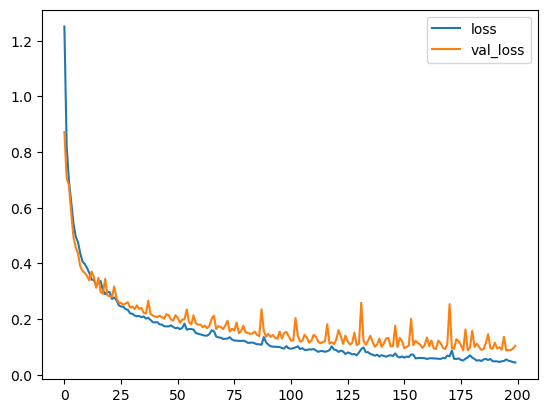

In [641]:
results[['loss', 'val_loss']].plot()

In [642]:
#model2.load_weights(checkpoint_path2)

In [643]:
Y2_pred = model2.predict(sc.transform(X2_test))
y2_pred = np.argmax(Y2_pred, axis=1)
cnt = 0
for i, j in zip(y2_test, y2_pred):
    if(i ==j ):
        cnt = cnt +1
print(f'{cnt} of {y2_pred.shape[0]} are correct [{cnt/y2_test.shape[0]*100}%]')

10/10 [==============================] - 0s 886us/step
279 of 291 are correct [95.87628865979381%]


In [644]:
#model2.load_weights(checkpoint_path2)

In [645]:
Y2_pred = model2.predict(sc.transform(X2_test))
y2_pred = np.argmax(Y2_pred, axis=1)
cnt = 0
for i, j in zip(y2_test, y2_pred):
    if(i ==j ):
        cnt = cnt +1
print(f'{cnt} of {y2_test.shape[0]} are correct [{cnt/y2_test.shape[0]*100}%]')

10/10 [==============================] - 0s 886us/step
279 of 291 are correct [95.87628865979381%]


In [646]:
from pickle import dump

dump(sc, open('./minmax_scaler.pkl', 'wb'))